In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *

import matplotlib.pyplot as plt

import math
from utils import *

nS = 100
nA = 2
seed = 2184109
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, gamma=gamma, small=5, large=1000, seed=seed)
tau = 0.99
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)


In [2]:
alpha_tau = 0.0005
Qs = []
visit_distributions = []
taus = []
while tau < 1.00001 and tau > 0:
    Q_star = bellman_optimal_q(tmdp.P_mat_tau, tmdp.reward, tmdp.gamma)["Q"]
    pi = get_policy(Q_star)

    r_s_a_xi = compute_r_s_a(tmdp.xi, tmdp.reward)
    r_s_a_p = compute_r_s_a(tmdp.P_mat, tmdp.reward)
    r_s_a = compute_r_s_a(tmdp.P_mat_tau, tmdp.reward)

    if tmdp.tau == 1:
        q_xi = Q_star
        q_p = np.zeros((nS, nS))
    else:
        q_xi = get_q_hat(tmdp.xi, r_s_a_xi, tmdp.gamma, Q_star)
        q_p = (Q_star - tmdp.tau *q_xi)/(1-tmdp.tau)

    d = compute_d(mu, tmdp.P_mat_tau, pi, tmdp.gamma)

    grad = compute_grad_j(pi, q_p, q_xi, d, tmdp.gamma)
    print("Gradient: ", grad)
    Qs.append(Q_star)
    visit_distributions.append(d)
    taus.append(tmdp.tau)
    tau = max(0, tau + alpha_tau * grad)
    print("Updating tau from {} to {}".format(tmdp.tau, tau))
    tmdp.update_tau(tau)
print("Moving to the original problem")
Q_star = bellman_optimal_q(tmdp.P_mat_tau, tmdp.reward, tmdp.gamma)["Q"]
pi = get_policy(Q_star)

r_s_a_xi = compute_r_s_a(tmdp.xi, tmdp.reward)
r_s_a_p = compute_r_s_a(tmdp.P_mat, tmdp.reward)
r_s_a = compute_r_s_a(tmdp.P_mat_tau, tmdp.reward)

d = compute_d(mu, tmdp.P_mat_tau, pi, tmdp.gamma)

q_p = Q_star
q_xi = np.zeros((nS, nS))
grad = compute_grad_j(pi, q_p, q_xi, d, tmdp.gamma)
print("Gradient: ", grad)
Qs.append(Q_star)
visit_distributions.append(d)
taus.append(tmdp.tau)

Gradient:  -28.941041152749925
Updating tau from 0.99 to 0.975529479423625
Gradient:  -28.656252410055806
Updating tau from 0.975529479423625 to 0.9612013532185971
Gradient:  -28.376641120813904
Updating tau from 0.9612013532185971 to 0.9470130326581901
Gradient:  -28.102242267109624
Updating tau from 0.9470130326581901 to 0.9329619115246354
Gradient:  -27.83305698358874
Updating tau from 0.9329619115246354 to 0.919045383032841
Gradient:  -27.569075750190883
Updating tau from 0.919045383032841 to 0.9052608451577455
Gradient:  -27.310288296642874
Updating tau from 0.9052608451577455 to 0.891605701009424
Gradient:  -27.056700233265826
Updating tau from 0.891605701009424 to 0.8780773508927912
Gradient:  -26.808308793076616
Updating tau from 0.8780773508927912 to 0.8646731964962528
Gradient:  -26.565120503536654
Updating tau from 0.8646731964962528 to 0.8513906362444845
Gradient:  -26.327144767276163
Updating tau from 0.8513906362444845 to 0.8382270638608464
Gradient:  -26.094402900799498


In [3]:
metrics = compute_metrics(tmdp, Qs, Q_star, visit_distributions)


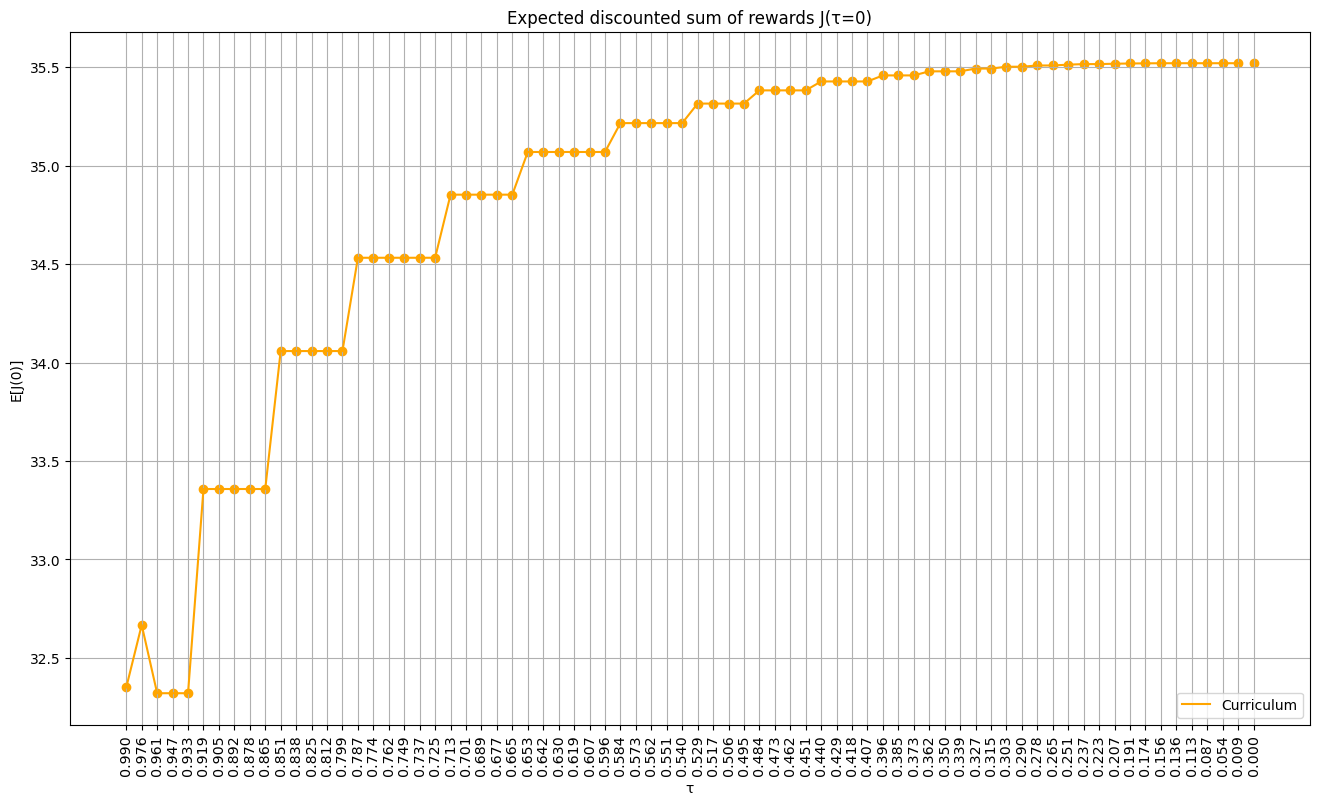

In [4]:
x = np.array([])
y = np.array([])

for i, J in enumerate(metrics["J"]):
    
    if i < len(metrics["J"])-1:
        x = np.append(x, "{:.3f}".format(taus[i]))
        y = np.append(y, J)

x_map = np.array([i for i in range(len(x))])
plt.figure(figsize=(16,9))
plt.xticks(rotation=90, fontsize=10.3)
plt.scatter(x, y, c="orange")
plt.plot(x[:-1], y[:-1], c="orange", label="Curriculum")
plt.legend(loc="lower right")
plt.xlabel("τ")
plt.ylabel("E[J(0)]")
plt.title("Expected discounted sum of rewards J(τ=0)")
plt.grid(visible=True)

In [15]:
tmdp_1 = TMDP(river, xi, tau=1., gamma=gamma, seed=seed)
Q_1 = bellman_optimal_q(tmdp_1.P_mat_tau, tmdp_1.reward, tmdp_1.gamma)["Q"]
pi_1 = get_policy(Q_1)

d_1 = compute_d(tmdp_1.mu, tmdp_1.P_mat_tau, pi_1, tmdp_1.gamma)

zeros = np.zeros((nS, nS))
grad_1 = compute_grad_j(pi_1, zeros, Q_1, d_1, tmdp_1.gamma)
print("Gradient: tau=1", grad_1)

tmdp_0 = TMDP(river, xi, tau=0., gamma=gamma, seed=seed)

Q_0 = bellman_optimal_q(tmdp_0.P_mat_tau, tmdp_0.reward, tmdp_0.gamma)["Q"]

pi_0 = get_policy(Q_0)
d_0 = compute_d(tmdp_0.mu, tmdp_0.P_mat_tau, pi_0, tmdp_0.gamma)

grad_0 = compute_grad_j(pi, Q_0, zeros, d_0, tmdp_0.gamma)
print("Gradient: tau=0", grad_0)

Gradient: tau=1 10.049982121559317
Gradient: tau=0 -510.51177917540406


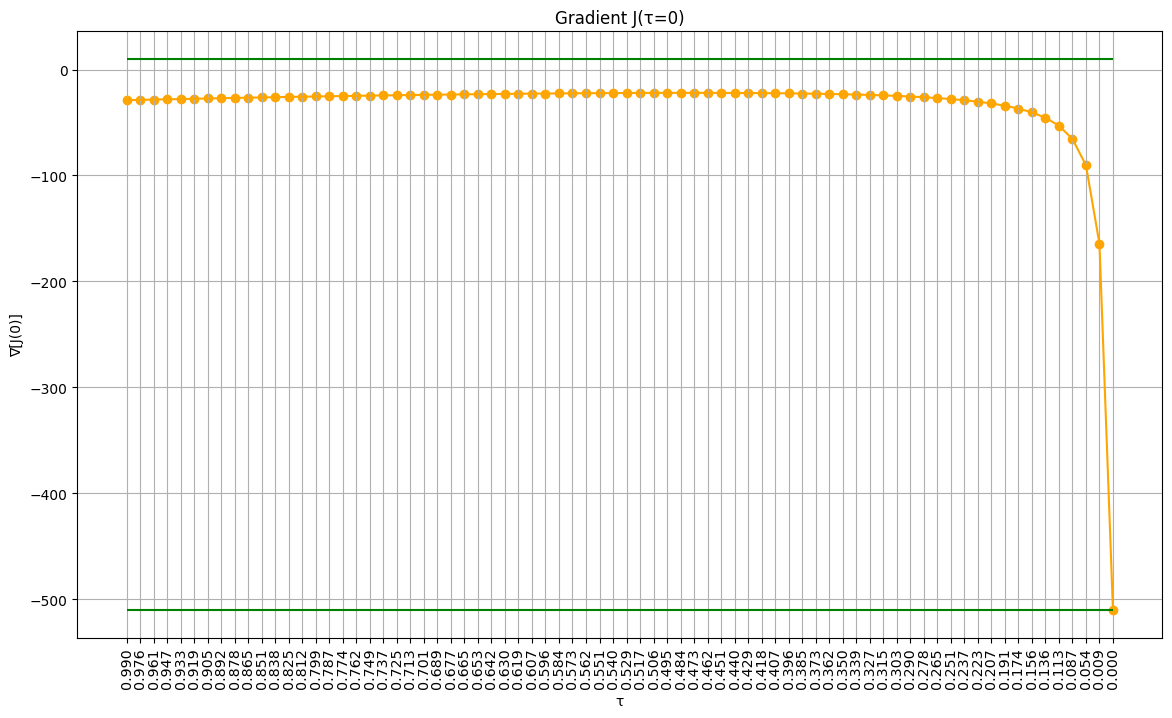

In [18]:
x = np.array([])
y = np.array([])
for i, J in enumerate(metrics["grad_J"]):
    if i < len(metrics["grad_J"])-1:
        x = np.append(x, "{:.3f}".format(taus[i]))
        if taus[i] != 0:
            y = np.append(y, J)
        else:
            y = np.append(y, grad_0)

x_map = np.array([i for i in range(len(x))])
plt.figure(figsize=(14,7.875))
plt.xticks(rotation=90, fontsize=10.3)
plt.scatter(x, y, c="orange")
plt.plot(x, y, c="orange", label="Curriculum")
#plt.legend(loc="lower right")
plt.xlabel("τ")
plt.ylabel("∇[J(0)]")
plt.title("Gradient J(τ=0)")
plt.grid(visible=True)
plt.hlines(y=grad_1, xmin=0, xmax=len(x)-1, colors='green', label='Optimal J')
plt.hlines(y=grad_0, xmin=0, xmax=len(x)-1, colors='green', label='Optimal J')